In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# With Wine Quality Data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

wine_data = pd.read_csv(url, sep=';')

wine_data = wine_data[wine_data['total sulfur dioxide']<200]

cols_zscore = wine_data.keys()
cols_zscore = cols_zscore.drop("quality")
wine_data[cols_zscore] = wine_data[cols_zscore].apply(stats.zscore)

wine_data["boolQuality"] = 0
wine_data["boolQuality"][wine_data["quality"]>5] = 1

C:\Users\drkum\AppData\Local\Temp\ipykernel_19136\1219900010.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_data["boolQuality"][wine_data["quality"]>5] = 1


In [3]:
data_tensor = torch.tensor(data=wine_data[cols_zscore].values).float()
label_tensor = torch.tensor(data=wine_data["boolQuality"].values).float()
label_tensor = label_tensor[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, label_tensor, test_size=0.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
def wineModel():
    annWine = nn.Sequential(nn.Linear(11, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, 1))

    loss_fun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.SGD(annWine.parameters(), lr=0.01)

    return annWine, loss_fun, optimizer

In [5]:
num_epochs = 1000

def trainWineModel():

    annWine, loss_fun, optimizer = wineModel()

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annWine.train()
        batch_loss = []
        batch_acc = []

        for x, y in train_loader:
            y_hat = annWine(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())

            batch_acc.append(100*torch.mean(((annWine(x) > 0) == y).float()).item())

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)

        annWine.eval()
        x, y  = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean(((annWine(x) > 0) == y).float()).item())

    return train_acc, test_acc, losses, annWine

In [6]:
train_acc, test_acc, losses, annWine = trainWineModel()

In [7]:
train_predictions = annWine(train_loader.dataset.tensors[0])
test_predictions = annWine(test_loader.dataset.tensors[0])

In [8]:
import sklearn.metrics as metrics

train_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]

train_metrics[0] = metrics.accuracy_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[1] = metrics.precision_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[2] = metrics.recall_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[3] = metrics.f1_score(train_loader.dataset.tensors[1], train_predictions>0)

test_metrics[0] = metrics.accuracy_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[1] = metrics.precision_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[2] = metrics.recall_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[3] = metrics.f1_score(test_loader.dataset.tensors[1], test_predictions>0)

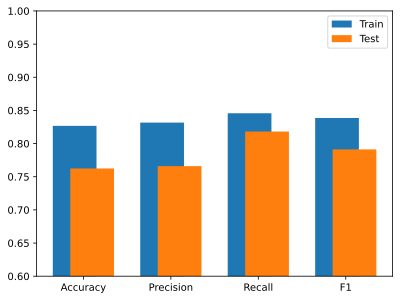

In [9]:
plt.bar(np.arange(4)-0.1, train_metrics, 0.5)
plt.bar(np.arange(4)+0.1, test_metrics, 0.5)
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1"])
plt.ylim([0.6, 1])
plt.legend(["Train", "Test"]);

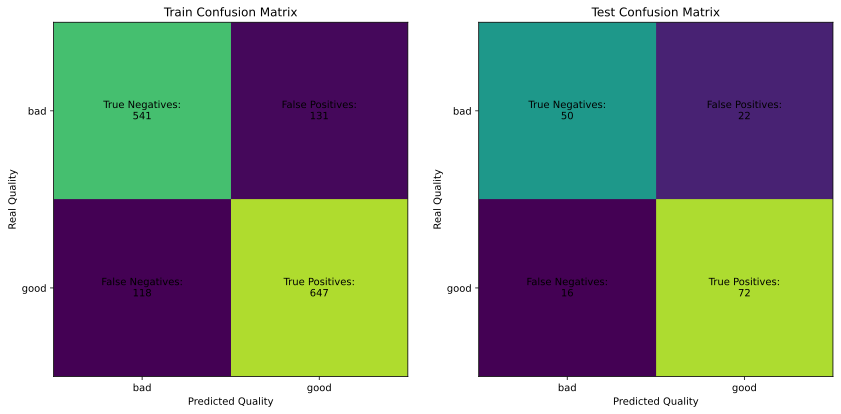

In [10]:
train_confusion = metrics.confusion_matrix(train_loader.dataset.tensors[1], train_predictions>0)
test_confusion = metrics.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

_, axis = plt.subplots(1, 2, figsize=(14, 8))

axis[0].imshow(train_confusion, vmax=len(train_predictions)/2)
axis[0].set_yticks([0, 1])
axis[0].set_xticks([0, 1])
axis[0].set_yticklabels(["bad", "good"])
axis[0].set_xticklabels(["bad", "good"])
axis[0].set_xlabel("Predicted Quality")
axis[0].set_ylabel("Real Quality")
axis[0].set_title("Train Confusion Matrix")

axis[0].text(0, 0, f"True Negatives:\n{train_confusion[0, 0]}", ha="center", va="center")
axis[0].text(0, 1, f"False Negatives:\n{train_confusion[1, 0]}", ha="center", va="center")
axis[0].text(1, 1, f"True Positives:\n{train_confusion[1, 1]}", ha="center", va="center")
axis[0].text(1, 0, f"False Positives:\n{train_confusion[0, 1]}", ha="center", va="center")

axis[1].imshow(test_confusion, vmax=len(test_predictions)/2)
axis[1].set_yticks([0, 1])
axis[1].set_xticks([0, 1])
axis[1].set_yticklabels(["bad", "good"])
axis[1].set_xticklabels(["bad", "good"])
axis[1].set_xlabel("Predicted Quality")
axis[1].set_ylabel("Real Quality")
axis[1].set_title("Test Confusion Matrix")

axis[1].text(0, 0, f"True Negatives:\n{test_confusion[0, 0]}", ha="center", va="center")
axis[1].text(0, 1, f"False Negatives:\n{test_confusion[1, 0]}", ha="center", va="center")
axis[1].text(1, 1, f"True Positives:\n{test_confusion[1, 1]}", ha="center", va="center")
axis[1].text(1, 0, f"False Positives:\n{test_confusion[0, 1]}", ha="center", va="center");

# With MNIST Data

In [11]:
mnist_data = np.loadtxt(open("mnist_train_small.csv"), delimiter=',')

labels = mnist_data[:, 0]
data = mnist_data[:, 1:]
data_norm = (data > 128).astype(int)

In [12]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
def annMnistModel():

    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 64)

            self.hidden_1 = nn.Linear(64, 32)
            self.hidden_2 = nn.Linear(32, 32)

            self.output = nn.Linear(32, 10)

        def forward(self, x):
            x = self.input(x)
            x = F.relu(x)

            x = self.hidden_1(x)
            x = F.relu(x)

            x = self.hidden_2(x)
            x = F.relu(x)

            return torch.log_softmax(self.output(x), axis=1)

    annMnist = AnnMnist()

    loss_fun = nn.NLLLoss()

    optimizer = torch.optim.SGD(annMnist.parameters(), lr=0.01)

    return annMnist, loss_fun, optimizer

In [14]:
num_epochs = 100

def trainModel():

    annMnist, loss_fun, optimizer = annMnistModel()

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annMnist.train()

        batch_loss = []
        batch_acc = []

        for x, y in train_dataloader:
            y_hat = annMnist(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

        train_acc.append(np.mean(batch_acc))

        losses[epoch] = np.mean(batch_loss)

        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(annMnist(x), axis=1) == y).float()))

    return train_acc, test_acc, losses, annMnist

In [15]:
train_acc, test_acc, losses, annMnist = trainModel()

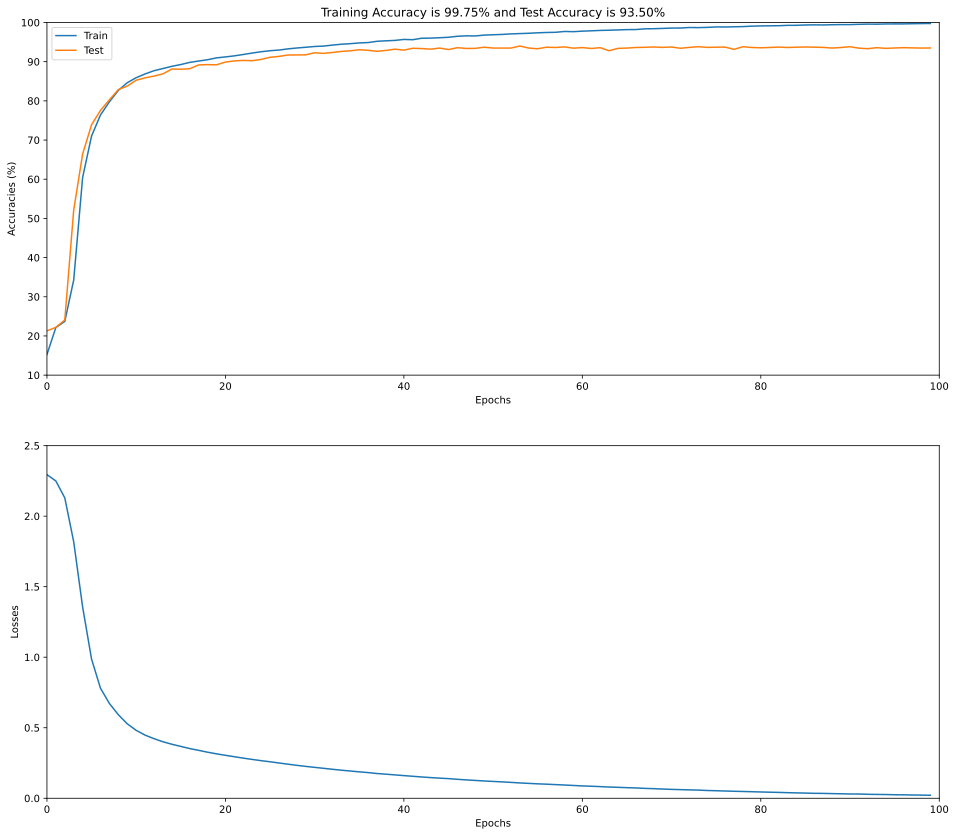

In [16]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(losses.detach())
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].set_xlim([0, 100])
axis[1].set_ylim([0, 2.5]);

In [17]:
train_predictions = torch.argmax(annMnist(train_dataloader.dataset.tensors[0]),axis=1)
test_predictions = torch.argmax(annMnist(test_dataloader.dataset.tensors[0]), axis=1)

In [18]:
wtrain_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]

train_metrics[0] = metrics.accuracy_score(train_dataloader.dataset.tensors[1], train_predictions)
train_metrics[1] = metrics.precision_score(train_dataloader.dataset.tensors[1], train_predictions, average="weighted")
train_metrics[2] = metrics.recall_score(train_dataloader.dataset.tensors[1], train_predictions, average="weighted")
train_metrics[3] = metrics.f1_score(train_dataloader.dataset.tensors[1], train_predictions, average="weighted")

test_metrics[0] = metrics.accuracy_score(test_dataloader.dataset.tensors[1], test_predictions)
test_metrics[1] = metrics.precision_score(test_dataloader.dataset.tensors[1], test_predictions, average="weighted")
test_metrics[2] = metrics.recall_score(test_dataloader.dataset.tensors[1], test_predictions, average="weighted")
test_metrics[3] = metrics.f1_score(test_dataloader.dataset.tensors[1], test_predictions, average="weighted")

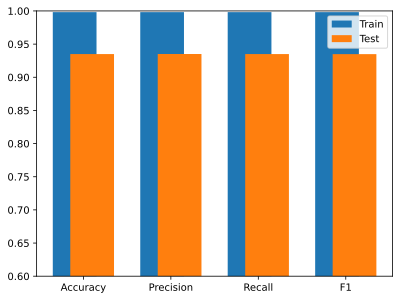

In [19]:
plt.bar(np.arange(4)-0.1, train_metrics, 0.5)
plt.bar(np.arange(4)+0.1, test_metrics, 0.5)
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1"])
plt.ylim([0.6, 1])
plt.legend(["Train", "Test"]);

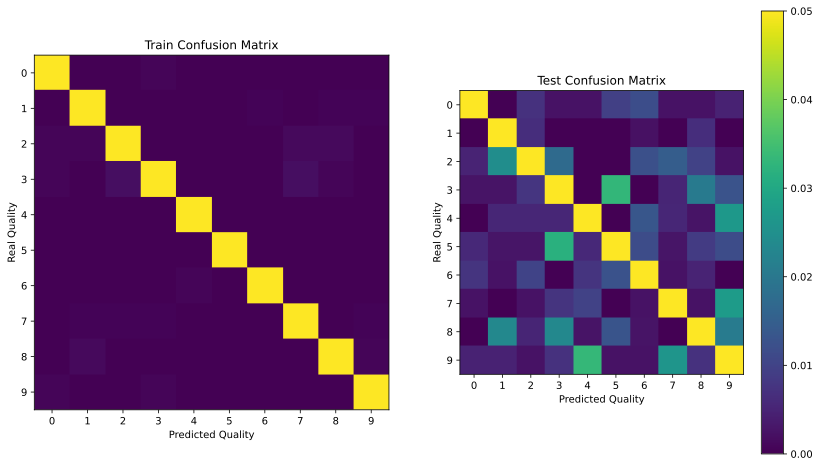

In [20]:
train_confusion = metrics.confusion_matrix(train_dataloader.dataset.tensors[1], train_predictions, normalize='true')
test_confusion = metrics.confusion_matrix(test_dataloader.dataset.tensors[1], test_predictions, normalize='true')

fig, axis = plt.subplots(1, 2, figsize=(14, 8))

axis[0].imshow(train_confusion, vmax=0.05)
axis[0].set_yticks(range(10))
axis[0].set_xticks(range(10))
axis[0].set_xlabel("Predicted Quality")
axis[0].set_ylabel("Real Quality")
axis[0].set_title("Train Confusion Matrix")

a = axis[1].imshow(test_confusion, vmax=0.05)
axis[1].set_yticks(range(10))
axis[1].set_xticks(range(10))
axis[1].set_xlabel("Predicted Quality")
axis[1].set_ylabel("Real Quality")
axis[1].set_title("Test Confusion Matrix")

fig.colorbar(a);